In [3]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [4]:
!pip install transformers
!pip install transformers datasets
!pip install --upgrade accelerate
!pip install evaluate
!pip install scikit-learn
!pip install matplotlib seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 9.9 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 5.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-m

In [5]:
from transformers import pipeline
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from datasets import load_dataset
from transformers import TrainingArguments, Trainer
import numpy as np
import evaluate

In [ ]:
# sentiment_pipeline = pipeline("sentiment-analysis")
# data = ["I love you", "I hate you"]
# sentiment_pipeline(data)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

[{'label': 'POSITIVE', 'score': 0.9998656511306763},
 {'label': 'NEGATIVE', 'score': 0.9991129040718079}]

Fine-tuning BERT

In [6]:
torch.cuda.empty_cache() # Empty the cache

# Get the sst2 dataset
dataset = load_dataset("SetFit/sst2")
print(dataset["train"][0])

# Get the tokenizer for the distilbert base uncased model
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Repo card metadata block was not found. Setting CardData to empty.


Generating train split:   0%|          | 0/6920 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

{'text': 'a stirring , funny and finally transporting re-imagining of beauty and the beast and 1930s horror films', 'label': 1, 'label_text': 'positive'}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [7]:
# Function to tokenize the dataset
def tokenize_dataset(data):
  return tokenizer(data["text"], padding="max_length", truncation=True)

# Tokenize the entrie dataset
tokenized_data = dataset.map(tokenize_dataset, batched=True)

# Use the validation dataset to show progress during training
train_dataset = tokenized_data["train"]
eval_dataset = tokenized_data["validation"]

Map:   0%|          | 0/6920 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

In [8]:
# Log in to huggingface so we can save the model
from huggingface_hub import notebook_login
notebook_login()

In [9]:
repo_name = "finetuning-sentiment-model"

# Get the model for training
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

configuration = model.config
print(configuration)

# Define the training arguments
training_args = TrainingArguments(
    output_dir=repo_name,
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=5e-5,
    #warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    evaluation_strategy="epoch",
)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.40.2",
  "vocab_size": 30522
}



In [ ]:
# Function to compute the accuracy for training
# metric = evaluate.load("accuracy")

# def compute_metrics(eval_pred):
#     pred, labels = eval_pred
#     predictions = np.argmax(pred, axis=-1)
#     return metric.compute(predictions=predictions, references=labels)

In [10]:
# from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, accuracy_score

# # Function to compute the accuracy for training
# metric = evaluate.load("accuracy")

# def compute_metrics(eval_pred):
#     pred, labels = eval_pred
#     predictions = np.argmax(pred, axis=-1)
#     precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
#     conf_matrix = confusion_matrix(labels, predictions)
#     accuracy = accuracy_score(labels, predictions)

#     return {
#         'accuracy': accuracy,
#         'precision': precision,
#         'recall': recall,
#         'f1': f1,
#         'confusion_matrix': conf_matrix.tolist()  # convert numpy array to list for better output handling
#     }

from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, accuracy_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    conf_matrix = confusion_matrix(labels, predictions)
    accuracy = accuracy_score(labels, predictions)

    # Print the confusion matrix
    print("Confusion Matrix:")
    print(conf_matrix)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }


In [11]:
# Define the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

In [12]:
# Fine-tune the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.302300,0.259659,0.894495,0.907407,0.882883,0.894977
2,0.130000,0.419273,0.888761,0.859213,0.934685,0.895361
3,0.076600,0.505182,0.891055,0.873662,0.918919,0.895719


Confusion Matrix:
[[388  40]
 [ 52 392]]
Confusion Matrix:
[[360  68]
 [ 29 415]]
Confusion Matrix:
[[369  59]
 [ 36 408]]


TrainOutput(global_step=1299, training_loss=0.1846777788027146, metrics={'train_runtime': 1031.0088, 'train_samples_per_second': 20.136, 'train_steps_per_second': 1.26, 'total_flos': 2750023196098560.0, 'train_loss': 0.1846777788027146, 'epoch': 3.0})

In [15]:
# Evaluate the fine-tuned model using the test dataset
# eval_result = trainer.evaluate(tokenized_data["test"])
# print(f"Test result: {eval_result}")

eval_results = trainer.evaluate(tokenized_data["test"])
print(f"Test result: {eval_results}")

# Push the model to the Hub
trainer.push_to_hub()

Confusion Matrix:
[[801 111]
 [ 63 846]]
Test result: {'eval_loss': 0.4371410310268402, 'eval_accuracy': 0.9044481054365733, 'eval_precision': 0.8840125391849529, 'eval_recall': 0.9306930693069307, 'eval_f1': 0.9067524115755627, 'eval_runtime': 34.2788, 'eval_samples_per_second': 53.123, 'eval_steps_per_second': 3.326, 'epoch': 3.0}


CommitInfo(commit_url='https://huggingface.co/my777/finetuning-sentiment-model/commit/373a9cb6c0e80b66af51ec3aca697cba62f8a087', commit_message='End of training', commit_description='', oid='373a9cb6c0e80b66af51ec3aca697cba62f8a087', pr_url=None, pr_revision=None, pr_num=None)

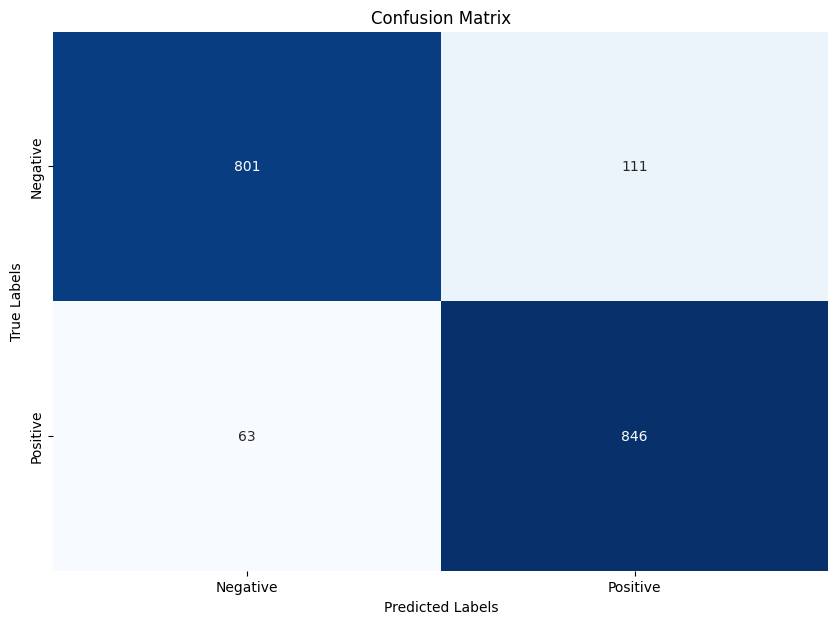

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(conf_matrix, class_names):
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

confusion_matrix = [[801, 111], [63, 846]] # change this based on the result
# Assuming 'conf_matrix' is the confusion matrix and 'class_names' are the names of the classes
class_names = ['Negative', 'Positive']  # Adjust these based on your specific classes
plot_confusion_matrix(confusion_matrix, class_names)

# Inference Test

In [ ]:
# See if we can use GPU to speed up
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device('cpu')

# Create 4 custom sentences
sentences = [
    "This TV show has some terrible characters.",
    "This movie is amazing!",
    "I hated the ending of the film.",
    "The book was fantastic.",
]

# Encode and tokenize the sentences
tokenized_inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")
tokenized_inputs.to(device)

# Predict the sentiment using the model
outputs = model(**tokenized_inputs)
prediction = outputs.logits.argmax(dim=1)

for sentence, prediction in zip(sentences, prediction):
    print(f"Sentence: {sentence}")
    if prediction.item() == 1:
      print("Sentiment Prediction: Positive")
    else:
      print("Sentiment Prediction: Negative")

# Finetune with a twitter dataset with three classes

In [ ]:
# Log in to huggingface so we can save the model
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
# torch.cuda.empty_cache() # Empty the cache

# Load the dataset
dataset = load_dataset("sentiment140")
print(dataset["train"][0])

# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Function to encode the data
def encode_data(example):
    encoding = tokenizer(example['text'], truncation=True, padding='max_length', max_length=128)
    encoding['labels'] = example['sentiment']

    return encoding

# Encode the dataset
encoded_dataset = dataset.map(encode_data, batched=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/1600000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/498 [00:00<?, ? examples/s]

{'text': "@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D", 'date': 'Mon Apr 06 22:19:45 PDT 2009', 'user': '_TheSpecialOne_', 'sentiment': 0, 'query': 'NO_QUERY'}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/1600000 [00:00<?, ? examples/s]

Map:   0%|          | 0/498 [00:00<?, ? examples/s]

In [ ]:
def label_adjust(example):
    if example['labels'] == 4:
        example['labels'] = 2
    elif example['labels'] == 2:
        example['labels'] = 1
    return example

# Adjust the labels in the dataset
encoded_dataset = encoded_dataset.map(label_adjust)

# # Checking label validity
# labels = encoded_dataset['train']['labels']
# labels_tensor = torch.tensor(labels)
# if labels_tensor.max() >= 3 or labels_tensor.min() < 0:
#     raise ValueError("Labels out of range. Must be between 0 and 2 for three classes.")

# # Checking data types
# print(f"Data type of inputs: {encoded_dataset['train']['input_ids'].dtype}")
# print(f"Data type of labels: {encoded_dataset['train']['labels'].dtype}")


Map:   0%|          | 0/1600000 [00:00<?, ? examples/s]

Map:   0%|          | 0/498 [00:00<?, ? examples/s]

In [ ]:
repo_name = "finetuning-sentiment-model-three_classes"

# training_args = TrainingArguments(
#     output_dir=repo_name,          # output directory
#     num_train_epochs=3,              # number of training epochs
#     per_device_train_batch_size=16,  # batch size for training
#     per_device_eval_batch_size=64,   # batch size for evaluation
#     warmup_steps=500,                # number of warmup steps for learning rate scheduler
#     weight_decay=0.01,               # strength of weight decay
#     logging_dir='./logs',            # directory for storing logs
#     logging_steps=10,
#     evaluation_strategy="epoch",
# )

# Define the training arguments
training_args = TrainingArguments(
    output_dir=repo_name,
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    learning_rate=5e-5,
    #warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    evaluation_strategy="epoch",
)

# Load the DistilBERT model
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

# Function to compute the accuracy for training
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    pred, labels = eval_pred
    predictions = np.argmax(pred, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

# Define the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset['train'],
    eval_dataset=encoded_dataset['test'],
    compute_metrics=compute_metrics,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer.train()

In [ ]:
# Push the model to the Hub
trainer.push_to_hub()
# model.save_pretrained('./sentiment_distilbert')
# tokenizer.save_pretrained('./sentiment_distilbert')